In [1]:
#Required functions for data utilization/ analysis
!pip install scanpy
!pip install biopython
import numpy as np
import pandas as pd
import os
import seaborn as sns
import warnings
import scanpy as sc
from Bio import SeqIO
import math
from anndata import AnnData
from collections import Counter
import sys
import errno

In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow.python as tf
import seaborn as sns
from Bio import SeqIO
from tqdm import tqdm
import time
from rhabdo_utils import *
from rhabdo_lstm import LSTMLanguageModel

fname = 'all_rhabdo.fasta'
seqs = {}

for record in SeqIO.parse(fname, 'fasta'):
    if len(record.seq) < 1000:
        continue
    if str(record.seq).count('X') > 0:
        continue
    if record.seq not in seqs:
        seqs[record.seq] = []
    meta = parse_viprbr_r(record.description)

    seqs[record.seq].append(meta)

AAs = [
    'A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H',
    'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W',
    'Y', 'V', 'X', 'Z', 'J', 'U', 'B',
]

family_seqs = {}

for seq in seqs:
    for meta in seqs[seq]:
        if ('lyssa' in meta['strain'] and 'Rabies' not in meta['strain']) or 'vesicul' in meta['strain']:
            family_seqs[seq] = seqs[seq]
            break
obs = {}
obs["family"] = []
obs['n_seq'] = []
obs['seq'] = []    
adata = sc.read_h5ad("rhabdo_embed.h5ad")
for seq in family_seqs:
    meta = family_seqs[seq][0]

    for key in meta:
        if key == 'embedding':
            continue
        if key not in obs:
            obs[key] = []
        if 'vesicul' in meta[key]:
            if 'Chandipura' in meta[key]:
                obs['family'].append('Vesiculovirus - Chandipura');
            else:
                obs['family'].append('Vesiculovirus - Other');
        elif 'lyssa' in meta[key]:
            if meta['continent'] != 'NA':
                obs['family'].append('Lyssavirus - {}'.format(meta['continent'].split()[0]))
            else:
                obs['family'].append('Lyssavirus - Other')
        obs[key].append(Counter([
        meta[key] for meta in seqs[seq]
    ]).most_common(1)[0][0])
    obs['n_seq'].append(len(seqs[seq]))
    obs['seq'].append(str(seq))

for key in obs:
    adata.obs[key] = obs[key]
print (np.asarray(adata.X))

[[ 0.00061585  0.03927067  0.18389495 ... -0.08796199  0.07832536
  -0.2399686 ]
 [ 0.0032488   0.0458352   0.27311632 ... -0.05708079  0.07890908
  -0.27409756]
 [ 0.01228967  0.03683871  0.33113104 ... -0.04878894  0.06711507
  -0.32936174]
 ...
 [-0.00040109  0.0400225   0.24988803 ... -0.06744233  0.08069055
  -0.25421676]
 [-0.01039614  0.04670504  0.22214428 ... -0.08424848  0.08515474
  -0.22997633]
 [-0.00276115  0.04786149  0.2285128  ... -0.08177711  0.08568257
  -0.23665147]]


<Figure size 800x800 with 0 Axes>

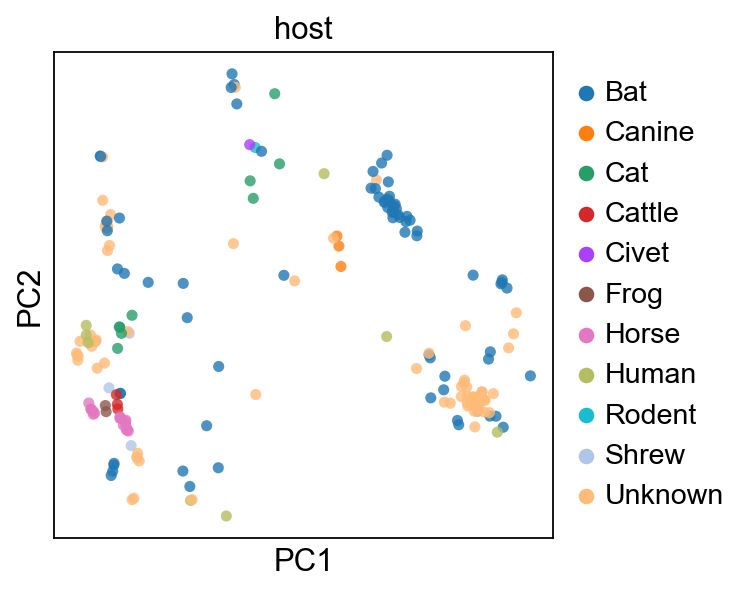

<Figure size 800x800 with 0 Axes>

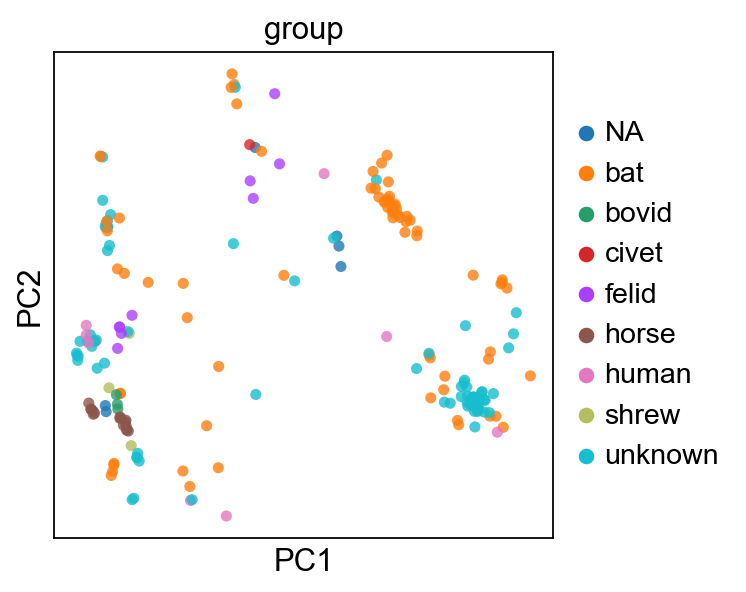

<Figure size 800x800 with 0 Axes>

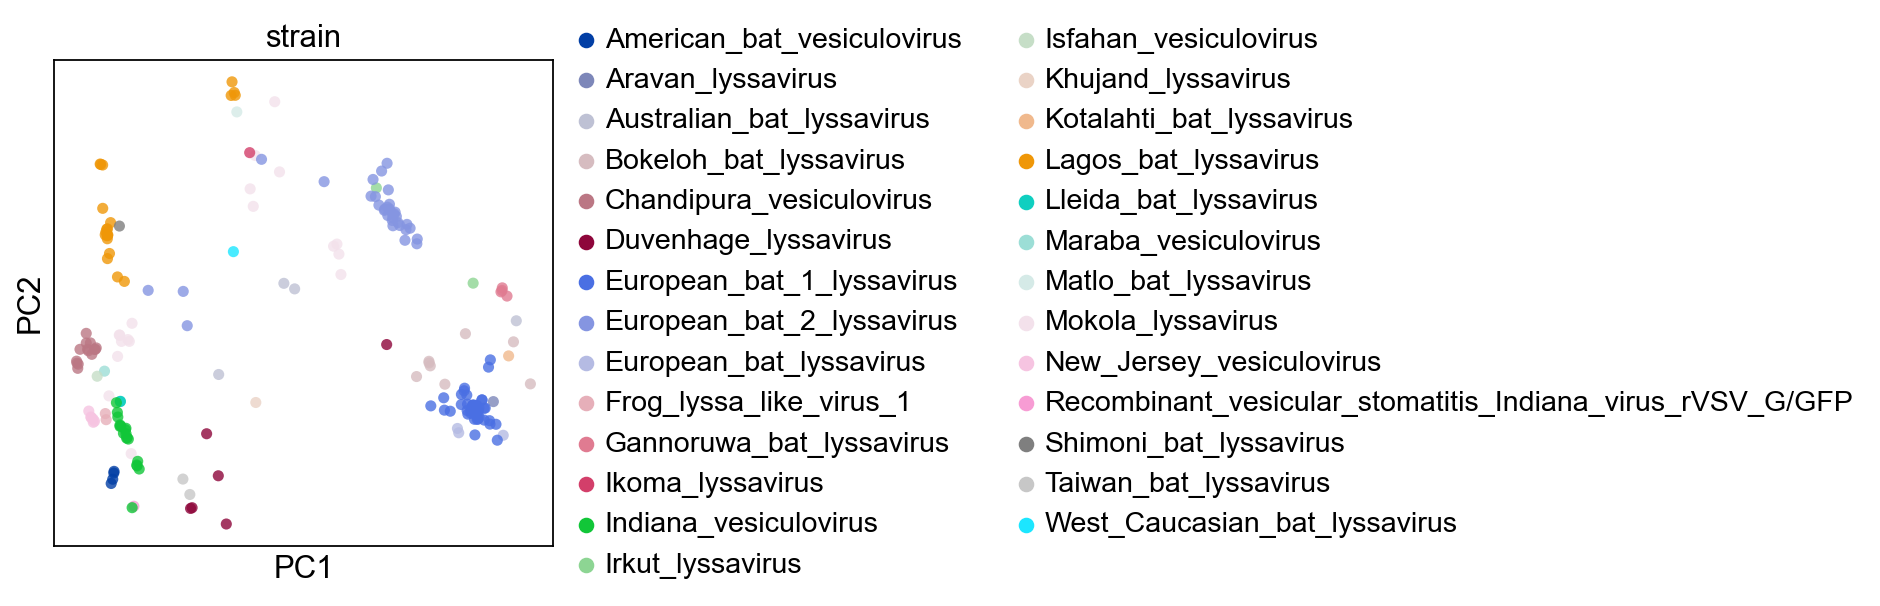

<Figure size 800x800 with 0 Axes>

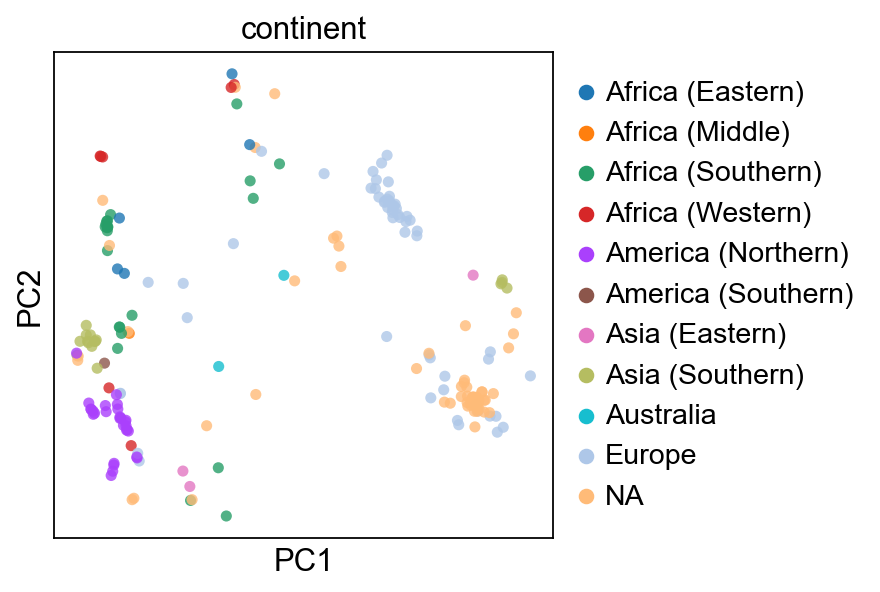

<Figure size 800x800 with 0 Axes>

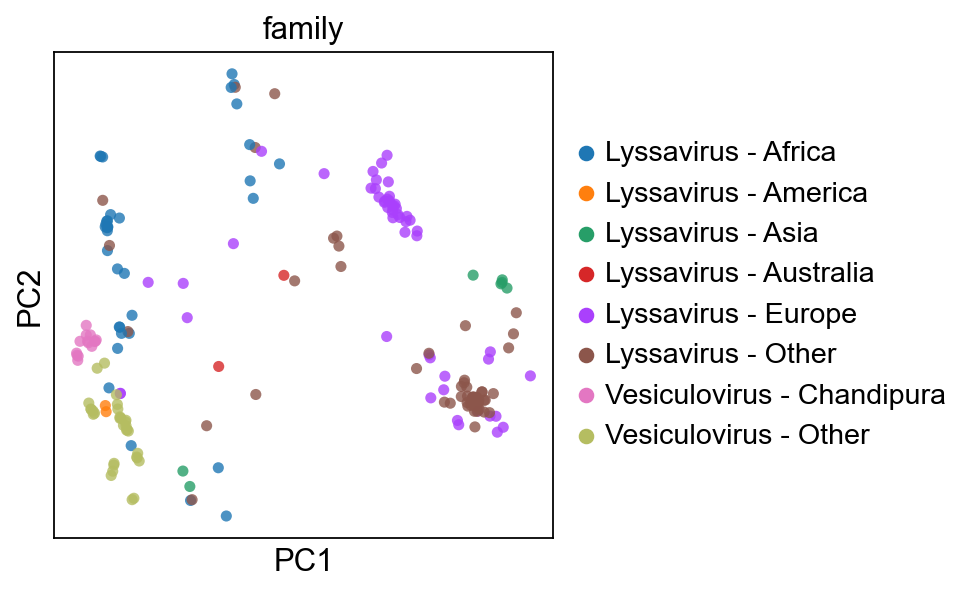

<Figure size 800x800 with 0 Axes>

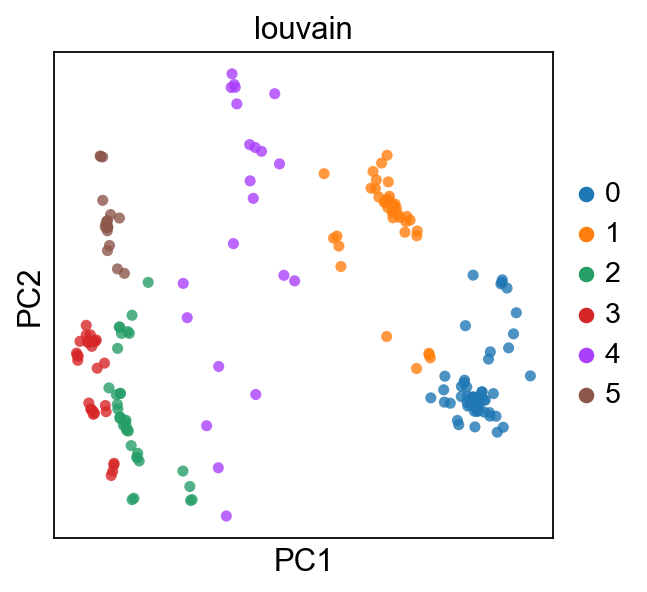

In [17]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=20, use_rep='X')
sc.tl.louvain(adata, resolution=1.)

sc.set_figure_params(dpi_save=500)
plot_pca(adata, [ 'host', 'group', 'strain', 'continent', 'family', 'louvain' ])
